In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import gym
import gym_minigrid
from gym_minigrid.wrappers import *
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from control.replay import Transition, ReplayMemory, Episode, EpisodeReplayMemory
import models.rnn as rnn
import models.attentive as attentive

In [2]:
class CustomImgObsWrapper(ImgObsWrapper):
    """
    Flatten the output.
    """

    def observation(self, obs):
        return torch.flatten(torch.tensor(super(CustomImgObsWrapper, self).observation(obs)))

class CustomFullyObsWrapper(FullyObsWrapper):
    """
    Flatten the output.
    """

    def observation(self, obs):
        return torch.flatten(torch.tensor(super(CustomFullyObsWrapper, self).observation(obs)))

In [3]:
#env = gym.make('CartPole-v0') #.unwrapped

env = gym.make('MiniGrid-Empty-5x5-v0')
env = CustomFullyObsWrapper(env)

#env = gym.make('MiniGrid-Empty-5x5-v0')
#env = CustomImgObsWrapper(env)

#env = gym.make('MiniGrid-Empty-5x5-v0')
#env = AgentViewWrapper(env)
#env = CustomImgObsWrapper(env)

n_observations = np.prod(env.observation_space.shape)
n_actions = env.action_space.n

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

/anaconda3/envs/rl/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [4]:
BATCH_SIZE = 32
GAMMA = 0.999
N_EPISODES = 10000
MAX_T = 200
#EPS_START, EPS_END, EPS_DECAY = 0.9, 0.05, 200
EPS_START, EPS_END, EPS_DECAY = 0.1, 0.1, 200
TARGET_UPDATE = 10
SEGMENT = 100

model_parameters = dict(
    network_type='mlp',
    input_dimension=n_observations,
    hidden_dimension=200,
    output_dimension=n_actions
)

In [5]:
class DQN(nn.Module):

    def __init__(self, input_dimension, hidden_dimension, output_dimension, network_type='mlp'):
        super(DQN, self).__init__()
        
        self.network_type = network_type
        
        if network_type == 'mlp':
            self.model = nn.Sequential(
                nn.Linear(input_dimension, 1000),
                nn.ReLU(),
                nn.Linear(1000, output_dimension)
            )
        elif network_type == 'att':
            self.model = attentive.Attentive(input_dim=4, hidden_dimensions=(64, 64, 64, 64), 
                                             memory_size=256, memory_dimension=32, 
                                             key_dimension=16, output_dim=2)
        else:
            self.model = rnn.RNN(input_dimension=4, hidden_dimension=hidden_dimension // 2, n_actions=2, dropout=0)

    def forward(self, x, mask=None):
        if self.network_type in {'mlp', 'att'}:
            return self.model(x)
        else:
            return self.model(x, mask)
    
    def reset(self):
        if self.network_type == 'rnn':
            self.model.reset()
            
    def predict(self, x):
        if self.network_type in {'mlp', 'att'}:
            return self.model(x)
        else:
            return self.model.predict(x)

In [6]:
policy_net = DQN(**model_parameters).to(device)
target_net = DQN(**model_parameters).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# optimizer = optim.SGD(policy_net.parameters(), lr=.01)
optimizer = optim.Adam(policy_net.parameters(), lr=.001, betas=(.9, .99))
# optimizer = optim.RMSprop(policy_net.parameters(), lr=.001)
# optimizer = eligibility.EligibilitySGD(policy_net.parameters(), lr=.9, gamma=.9, lambd=.9)

episode_memory = EpisodeReplayMemory(400)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net.predict(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

def select_action_greedy(state):
    with torch.no_grad():
            return policy_net.predict(state).max(1)[1].view(1, 1)


full_returns_train, full_returns_test = [], []


def plot_returns(max_points=N_EPISODES, mean_window=SEGMENT):
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.figure(2)
    plt.clf()

    returns_train = torch.tensor(full_returns_train, dtype=torch.float)
    returns_test = torch.tensor(full_returns_test, dtype=torch.float)
    t = np.arange(len(full_returns_train))

    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Returns')
    
    plt.plot(t[-max_points:], returns_train.numpy()[-max_points:], label='train')
    plt.plot(t[-max_points:], returns_test.numpy()[-max_points:], label='test')

    # Take 100 episode averages and plot them too
    if len(returns_train) >= mean_window:
        means = returns_train.unfold(0, mean_window, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(mean_window-1), means))
        plt.plot(t[-max_points:], means.numpy()[-max_points:], label='mean_train')

    plt.legend()
    #plt.pause(0.001)  # pause a bit so that plots are updated
    

In [7]:
def optimize_model_per_episode():
    if len(episode_memory) < BATCH_SIZE:
        return
    
    policy_net.reset()
    target_net.reset()
    
    episodes = episode_memory.sample(BATCH_SIZE)
    
    max_length = np.max([len(episode) for episode in episodes])
    episodes = np.array([episode.get_length(max_length) for episode in episodes])
    
    steps = episodes.swapaxes(0, 1)
    
    for i in range(len(steps)):
        
        batch = steps[i]
        
        episode_mask = np.array([b[0] is not None for b in batch], dtype=bool)
        episode_index = np.arange(len(episode_mask))[episode_mask]
        
        steps = steps[:, episode_index]
    
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*batch[episode_mask]))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor([s is not None for s in batch.next_state], device=device, dtype=torch.uint8)
        
        try:
            non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        except:
            non_final_next_states = None
        
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        mask = torch.tensor(episode_index)
        state_action_values = policy_net(state_batch, mask).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(len(batch.state), device=device)
        
        if non_final_next_states is not None:
            mask = torch.arange(len(batch.state))[non_final_mask == 1]
            next_state_values[non_final_mask] = target_net(non_final_next_states, mask).max(1)[0].detach()
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch.float()

        # Compute Huber loss
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        # for param in policy_net.parameters():
        #     param.grad.data.clamp_(-1, 1)
        optimizer.step()

In [8]:
def train_episode():
    policy_net.reset()
    
    # Initialize the environment and state
    state = torch.tensor(env.reset()).float().unsqueeze(0)  #.unsqueeze(0)
    episode = Episode()
    
    full_return = 0
    
    for t in count():
        # Select and perform an action
        action = select_action(state)
        s, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device, dtype=torch.float)
        
        full_return += reward
        
        if t + 1 == MAX_T:
            done = True

        # Observe new state
        if not done:
            next_state = torch.tensor(s).float().unsqueeze(0)  #.unsqueeze(0)
        else:
            next_state = None
            
        episode.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state
        
        if done:
            break
    
    return full_return, episode

def test_episode():
    
    # Initialize the environment and state
    state = torch.tensor(env.reset()).float().unsqueeze(0)  #.unsqueeze(0)
    
    full_return = 0
    
    for t in count():
        # Select and perform an action
        action = select_action(state)
        s, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device, dtype=torch.float)
        
        full_return += reward
        
        if t + 1 == MAX_T:
            done = True

        # Observe new state
        if not done:
            next_state = torch.tensor(s).float().unsqueeze(0)  #.unsqueeze(0)
        else:
            next_state = None

        # Move to the next state
        state = next_state
        
        if done:
            break
    
    return full_return

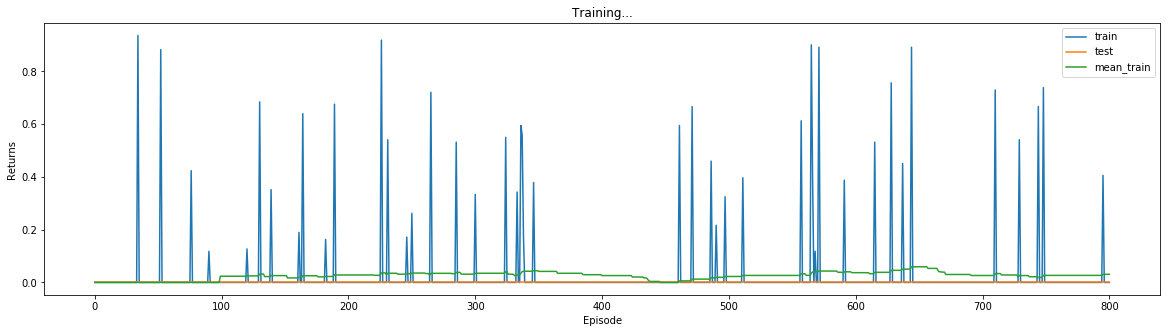

  9%|#####1                                                   | 902/10000 [07:33<1:22:42,  1.83it/s]

<Figure size 1440x360 with 0 Axes>

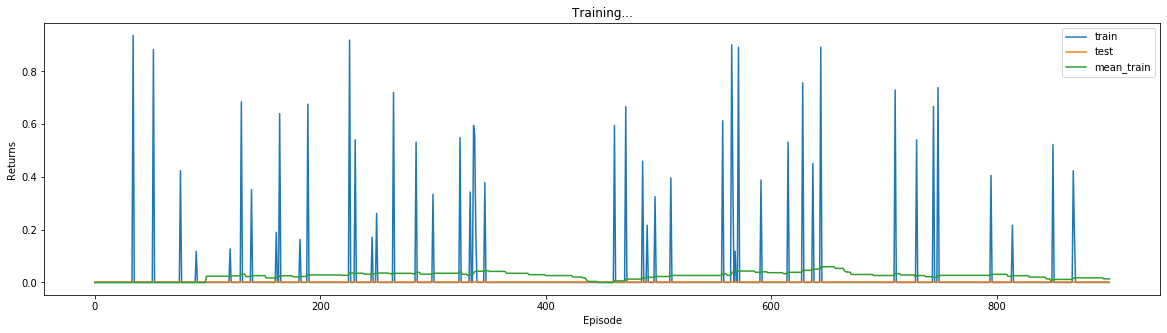

In [9]:
try:
    for i_episode in tqdm(range(N_EPISODES), ascii=True, ncols=100):

        full_return, episode = train_episode()
        full_returns_train.append(full_return)

        if i_episode % SEGMENT == 0:
            full_return = test_episode()
            if i_episode == 0:
                full_returns_test.extend([full_return])
            else:
                full_returns_test.extend([full_return for _ in range(SEGMENT)])

            plot_returns(max_points=1000)

        # Update the target network, copying all weights and biases in DQN
        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

        episode_memory.push(episode)

        # Perform one step of the optimization (on the target network)
        batch = optimize_model_per_episode()

        if batch is not None:
            break

    print('Complete')
    plt.ioff()
    plt.show()
except KeyboardInterrupt:
    pass

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

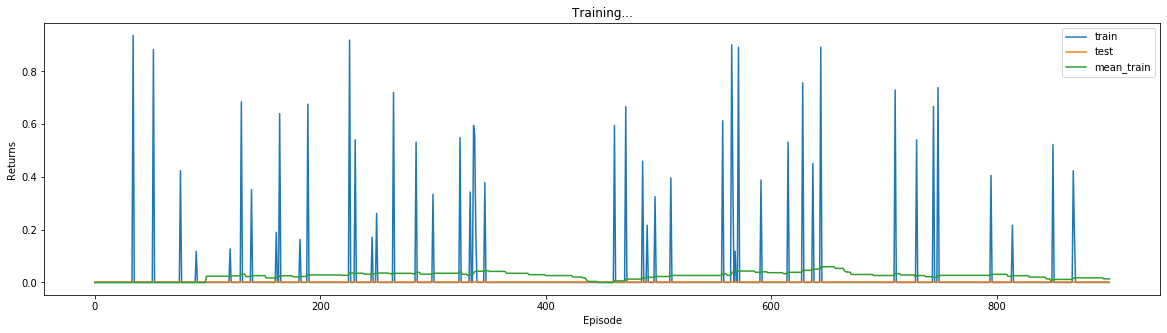

In [10]:
l = min(len(full_returns_train),len(full_returns_test))
full_returns_train = full_returns_train[:l]
full_returns_test = full_returns_test[:l]
plot_returns()